In [2]:
import pandas as pd
import numpy as np

import csv
import json

import re # Regular expressions

import itertools

import matplotlib.pyplot as plt
import mpld3

Basic draftsim analysis (by Bobby Mills and Arseny Khakhalin)

Change the set abbrevation below to work with a different set:

In [3]:
# Alternatives: DOM, GRN, M19
setName = 'GRN'

In [4]:
#mtgJSON = json.load(open('Allsets.json'))
with open('../data/Allsets.json', 'r',encoding='utf-8') as json_data:
    mtgJSON = json.load(json_data)
    
thisSet = mtgJSON[setName]['cards']

In [5]:
def fixName(name):
    res = re.sub(' ', '_', name)
    res = re.sub(',_', '_', res)
    res = re.sub('_\d+', '', res) #remove _number from lands
    res = re.sub('_\([a-zA-Z]\)', '', res) #remove guildgate types
    res = res.lower()
    return res

In [6]:
def getName(card):
    s = '_'
    #names only occurs in split cards
    if card['layout'] == 'split':
        return s.join(
            [fixName(x) for x in card['names']]) #format split card names
    else: #else just use name
        return fixName(card['name'])

In [7]:
def isLegendary(card):
    return 'supertypes' in card.keys() and 'Legendary' in card['supertypes']

In [8]:
def getCardColor(card):
    colors = ['W', 'U', 'B', 'R', 'G'] # Change that to proper color sequence at some point (including in plots below)
    pattern = "[W,U,B,R,G]"
    
    if 'manaCost' in card.keys():
        mana = re.findall(pattern, card['manaCost'])
        mana = list(set(mana))#delete duplicates
        if len(mana) == 0:
            return 0
        elif len(mana) > 1:
            return 1
        else:
            return colors.index(mana[0]) + 2
        return mana
    #for colored land cards
    elif 'colorIdentity' in card.keys():
        mana = card['colorIdentity']
        if len(mana) == 0:
            return 0
        elif len(mana) > 1:
            return 1
        else:
            return colors.index(mana[0]) + 2
        return mana
    #colorless lands
    else:
        return 0

In [9]:
thisSet = {getName(card) : card for card in thisSet} # a dict with names as indices for cards, for all cards in set

dict((k.lower(), v) for k, v in thisSet.items()) # Lowercase the keys
cardlist = list(thisSet.keys())

Change the data file below to work with the draftsim data you want

In [10]:
dataFileName = {
    'XLN': '05-31-18 Rows 500000-600000.csv',
    'DOM': '2018-04-16 Dominiaria initial data-2.csv',
    'M19': '../2018-08-23 m19 drafts round 2.csv',
    'GRN': '../2018-10-05 GRN Draft Data 1.csv',
}

draftData = pd.read_csv(dataFileName[setName], 
                       names = ['format', 'human', 'bot1', 'bot2', 'bot3', 'bot4', 'bot5', 'bot6', 'bot7'])

draftData.head()

,format,human,bot1,bot2,bot3,bot4,bot5,bot6,bot7
1901310,GRN,"Tajic,_Legion's_Edge,Goblin_Cratermaker,Vernad...","Niv-Mizzet,_Parun,Capture_Sphere,Watcher_in_th...","Status_Statue,Gateway_Plaza,Deadly_Visit,Under...","Lazav,_the_Multifarious,Selective_Snare,Citywa...","Midnight_Reaper,Healer's_Hawk,Collar_the_Culpr...","Lava_Coil,Luminous_Bonds,Rubblebelt_Boar,Hunte...","Luminous_Bonds,Etrata,_the_Silencer,Loxodon_Re...","Find_Finality,Severed_Strands,Douser_of_Lights..."
1901311,GRN,"Pelt_Collector,Gatekeeper_Gargoyle,Murmuring_M...","Discovery_Dispersal,Parhelion_Patrol,Blood_Ope...","Ritual_of_Soot,Hired_Poisoner,Ledev_Guardian,C...","Legion_Warboss,Justice_Strike,Cosmotronic_Wave...","Pelt_Collector,Dead_Weight,Prey_Upon,Sprouting...","Vraska,_Golgari_Queen,Siege_Wurm,Pitiless_Gorg...","Assassin's_Trophy,Hired_Poisoner,Rhizome_Lurch...","Integrity_Intervention,Luminous_Bonds,Invert_I..."
1901312,GRN,"Venerated_Loxodon,Pack's_Favor,Demotion,Ledev_...","Aurelia,_Exemplar_of_Justice,Lava_Coil,Goblin_...","Demotion,Prey_Upon,Dead_Weight,Siege_Wurm,Gate...","Vraska,_Golgari_Queen,Prey_Upon,Gatekeeper_Gar...","Watcher_in_the_Mist,Dead_Weight,Healer's_Hawk,...","Status_Statue,Spinal_Centipede,Burglar_Rat,Moo...","Luminous_Bonds,Inescapable_Blaze,Loxodon_Resto...","Crackling_Drake,Erratic_Cyclops,Fresh-Faced_Re..."
1901313,GRN,"Conclave_Guildmage,League_Guildmage,Flight_of_...","Affectionate_Indrik,Ritual_of_Soot,Severed_Str...","Capture_Sphere,Invert_Invent,Rampaging_Monumen...","Luminous_Bonds,Arboretum_Elemental,Severed_Str...","Lava_Coil,Boros_Challenger,Ornery_Goblin,Direc...","Hunted_Witness,Luminous_Bonds,Plaguecrafter,Bu...","Conclave_Tribunal,Rosemane_Centaur,Rosemane_Ce...","Quasiduplicate,Capture_Sphere,Piston-Fist_Cycl..."
1901315,GRN,"Boros_Challenger,Boros_Guildgate_2,Inspiring_U...","Ritual_of_Soot,Assure_Assemble,Dead_Weight,Col...","Legion_Warboss,Selective_Snare,Goblin_Craterma...","Luminous_Bonds,Demotion,Selesnya_Guildgate_2,L...","March_of_the_Multitudes,Sunhome_Stalwart,Ledev...","Dead_Weight,Flower_Flourish,Prey_Upon,Siege_Wu...","Tajic,_Legion's_Edge,Fire_Urchin,Direct_Curren...","Nightveil_Predator,Unexplained_Disappearance,G..."


In [15]:
# You can pick a card name to see what the mtgJSON looks like
#thisSet['gigantosaurus'] # M19
#thisSet['karn_scion_of_urza']
#thisSet['blade_instructor'] # grn

Main loop:

In [11]:
# Initialize all vars to collect data
cardpicks = {card : [] for card in cardlist} # Pick order

In [12]:
count = 0
player = 'human' # normally should be: human, but can also be bot1 or another bot
for draft in draftData[player]:
    draft = fixName(draft)
    draft = draft.lower()
    draft = draft.split(',')
    count = count+1                 # For debugging only
    colorCount = [0,0,0,0,0,0,0]
    for i in range(14):             # Only looking at 1st booster as God knows what happens after
        try:
            cardpicks[draft[i]].append(i+1)
            colorCount[getCardColor(thisSet[draft[i]])] += 1            
        except KeyError as e:
            print(draft)
            print(count)
            raise

In [13]:
for card in cardpicks:
    if cardpicks[card] == []:
        cardpicks[card].append(15)

In [14]:
cardpicksdf = pd.DataFrame({
        'avg' : [np.mean(cardpicks[card]) for card in cardpicks],
        'var' : [np.var(cardpicks[card]) for card in cardpicks],
        'count' : [len(cardpicks[card]) for card in cardpicks],
        'color' : [getCardColor(thisSet[card]) for card in cardpicks],
        'rarity' :[thisSet[card]['rarity'] for card in cardpicks],
        'legendary' : [1 if isLegendary(thisSet[card]) else 0 for card in cardpicks]
    }, list(cardpicks.keys()))
#cardpicksdf.head()

In [17]:
# Note, it saves to gitHub-visible folder, not to hidden 'data' folder:
cardpicksdf.to_csv('basic_data_'+setName+'.csv', index_label="name")

In [39]:
# Top several cards:
cardpicksdf.sort_values(by=['var'], ascending=False).head(12)

,avg,var,count,color,rarity,legendary
thousand-year_storm,9.165869,19.194516,2297,1,Mythic Rare,0
firemind's_research,7.381732,18.811131,3175,1,Rare,0
chance_for_glory,8.108232,18.015217,1968,1,Mythic Rare,0
mnemonic_betrayal,8.782915,17.338804,1990,1,Mythic Rare,0
ionize,7.363283,16.812561,4886,1,Rare,0
drowned_secrets,5.902308,16.733344,1863,3,Rare,0
steam_vents,7.657913,15.216547,5636,1,Rare,0
mausoleum_secrets,7.747492,15.126384,2293,4,Rare,0
omnispell_adept,7.464591,15.075979,2923,3,Rare,0
beacon_bolt,7.768774,14.964769,9268,1,Uncommon,0


In [40]:
colorkey = ['0', 'M', 'W', 'U', 'B', 'R', 'G']
colorid = ['#9F9F9F', 'DC03FD', '#F3C750', '#0E68AB', '#150B00', '#D3202A', '#00733E']
mplcolors = ['gray', 'mediumvioletred', 'orange', 'dodgerblue', 'black', 'red', 'g']

In [41]:
mplrarity = ['crimson','orange','gray', 'black', 'w']
rarity= ['Mythic Rare', 'Rare', 'Uncommon', 'Common', 'Basic Land']

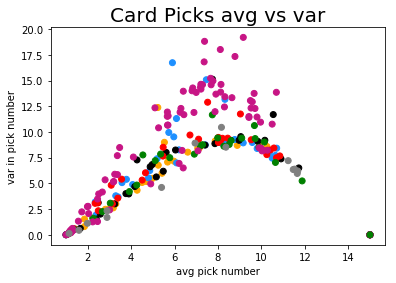

In [42]:
fig, ax = plt.subplots()

scatter = ax.scatter(cardpicksdf['avg'],
                     cardpicksdf['var'],
                     c = [mplcolors[x] for x in cardpicksdf['color']]
                    )

ax.set_title("Card Picks avg vs var", size=20)
plt.xlabel('avg pick number')
plt.ylabel('var in pick number') 

labels = list(cardpicksdf.index)
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

#plt.savefig('avgvsvar.png')

#mpld3.display()